In [18]:
import copy

import matplotlib.pyplot as plt

from itertools import combinations

In [19]:
graph = {}
with open("graph.txt", "r") as f:
    line = f.readline()
    while line:
        node_edges = line.split()
        node = node_edges[0]
        edges = node_edges[1:]
        graph[node] = set(edges)
        line = f.readline()
graph

{'A': {'B', 'C', 'D'}, 'B': {'A'}, 'C': {'A'}, 'D': {'A'}}

In [20]:
# graph = {
#     "A": {"B", "C", "D"},
#     "B": {"A"},
#     "C": {"A"},
#     "D": {"A"}
# }
nodes = list(graph.keys())
node_positions = {v: i for i, v in enumerate(nodes)}
print("Graph:")
graph

Graph:


{'A': {'B', 'C', 'D'}, 'B': {'A'}, 'C': {'A'}, 'D': {'A'}}

In [21]:
degree_of_nodes = {n: len(graph[n]) for n in nodes}

print("Degree of all nodes (starting from 0):")
degree_of_nodes # start from 0

Degree of all nodes (starting from 0):


{'A': 3, 'B': 1, 'C': 1, 'D': 1}

In [22]:
configurations = {
    tuple([0 for i in range(len(nodes))])
}
# perturb each state at a time for all states in configurations and accumulate the same in the configurations for next state to perturb
for n in nodes:
    node_pos = node_positions[n]
    config_copy = copy.deepcopy(configurations)
    for i in range(1, degree_of_nodes[n]+1):
        for cc in config_copy:
            cc = list(cc)
            cc[node_pos] = i
            configurations.add(tuple(cc))
            
print("All possible configurations:")
configurations, len(configurations)

All possible configurations:


({(0, 0, 0, 0),
  (0, 0, 0, 1),
  (0, 0, 1, 0),
  (0, 0, 1, 1),
  (0, 1, 0, 0),
  (0, 1, 0, 1),
  (0, 1, 1, 0),
  (0, 1, 1, 1),
  (1, 0, 0, 0),
  (1, 0, 0, 1),
  (1, 0, 1, 0),
  (1, 0, 1, 1),
  (1, 1, 0, 0),
  (1, 1, 0, 1),
  (1, 1, 1, 0),
  (1, 1, 1, 1),
  (2, 0, 0, 0),
  (2, 0, 0, 1),
  (2, 0, 1, 0),
  (2, 0, 1, 1),
  (2, 1, 0, 0),
  (2, 1, 0, 1),
  (2, 1, 1, 0),
  (2, 1, 1, 1),
  (3, 0, 0, 0),
  (3, 0, 0, 1),
  (3, 0, 1, 0),
  (3, 0, 1, 1),
  (3, 1, 0, 0),
  (3, 1, 0, 1),
  (3, 1, 1, 0),
  (3, 1, 1, 1)},
 32)

In [23]:
invariants = set()
for state in configurations:
    all_paths = combinations(range(len(state)), 2)
    for path in all_paths:
        source = nodes[path[0]]
        dest = nodes[path[1]]
        source_color = state[path[0]]
        dest_color = state[path[1]]
        if dest in graph[source] and source_color == dest_color:
            # found same color node between neighbors
            break
    else:
        invariants.add(state)

print("Invariants and Count of Invariants:")
invariants, len(invariants)

Invariants and Count of Invariants:


({(0, 1, 1, 1),
  (1, 0, 0, 0),
  (2, 0, 0, 0),
  (2, 0, 0, 1),
  (2, 0, 1, 0),
  (2, 0, 1, 1),
  (2, 1, 0, 0),
  (2, 1, 0, 1),
  (2, 1, 1, 0),
  (2, 1, 1, 1),
  (3, 0, 0, 0),
  (3, 0, 0, 1),
  (3, 0, 1, 0),
  (3, 0, 1, 1),
  (3, 1, 0, 0),
  (3, 1, 0, 1),
  (3, 1, 1, 0),
  (3, 1, 1, 1)},
 18)

In [24]:
program_transitions_rank = {}
for inv in invariants:
    program_transitions_rank[inv] = {"L": 0, "C": 1, "A": 0, "Ar": 0, "M": 0}

print("Program transitions rank for invariants:")
program_transitions_rank

Program transitions rank for invariants:


{(3, 0, 1, 1): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (3, 1, 1, 1): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (2, 1, 1, 0): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (0, 1, 1, 1): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (2, 0, 0, 1): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (3, 1, 1, 0): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (3, 0, 0, 1): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (2, 0, 0, 0): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (3, 0, 1, 0): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (3, 1, 0, 1): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (2, 0, 1, 1): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (2, 1, 0, 1): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (2, 1, 0, 0): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (3, 0, 0, 0): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (3, 1, 0, 0): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (1, 0, 0, 0): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (2, 1, 1, 1): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (2, 0, 1, 0):

In [25]:
def find_min_color(colors):
    for i in range(len(colors)+1):
        if i not in colors:
            return i

In [26]:
def is_program_transition(perturb_pos, dest_state):
    node = nodes[perturb_pos]
    neighbor_pos = [node_positions[n] for n in graph[node]]
    neighbor_colors = set(dest_state[i] for i in neighbor_pos)
    min_color = find_min_color(neighbor_colors)
    return dest_state[perturb_pos] == min_color

In [27]:
def get_program_transitions_cvfs(start_state):
    program_transitions = set()
    cvfs = set()
    for position, val in enumerate(start_state):
        possible_node_colors = set(range(degree_of_nodes[nodes[position]]+1))
        for perturb_val in possible_node_colors:
            perturb_state = list(start_state)
            perturb_state[position] = perturb_val
            perturb_state = tuple(perturb_state)
            if perturb_state != start_state:
                if is_program_transition(position, perturb_state):
                    program_transitions.add(perturb_state)
                else:
                    cvfs.add(perturb_state)
    return {"program_transitions": program_transitions, "cvfs": cvfs}

In [28]:
program_transitions_n_cvf = {}

for state in configurations:
    program_transitions_n_cvf[state] = get_program_transitions_cvfs(state)

print("All Program transitions and CVFs:")
program_transitions_n_cvf

All Program transitions and CVFs:


{(3,
  0,
  1,
  1): {'program_transitions': {(2, 0, 1, 1),
   (3, 0, 0, 1),
   (3, 0, 1, 0)}, 'cvfs': {(0, 0, 1, 1), (1, 0, 1, 1), (3, 1, 1, 1)}},
 (3,
  1,
  1,
  0): {'program_transitions': {(2, 1, 1, 0),
   (3, 0, 1, 0),
   (3, 1, 0, 0)}, 'cvfs': {(0, 1, 1, 0), (1, 1, 1, 0), (3, 1, 1, 1)}},
 (0, 1, 1, 0): {'program_transitions': {(0, 1, 1, 1), (2, 1, 1, 0)},
  'cvfs': {(0, 0, 1, 0), (0, 1, 0, 0), (1, 1, 1, 0), (3, 1, 1, 0)}},
 (2, 0, 0, 0): {'program_transitions': {(1, 0, 0, 0)},
  'cvfs': {(0, 0, 0, 0),
   (2, 0, 0, 1),
   (2, 0, 1, 0),
   (2, 1, 0, 0),
   (3, 0, 0, 0)}},
 (3,
  1,
  0,
  1): {'program_transitions': {(2, 1, 0, 1),
   (3, 0, 0, 1),
   (3, 1, 0, 0)}, 'cvfs': {(0, 1, 0, 1), (1, 1, 0, 1), (3, 1, 1, 1)}},
 (2, 0, 1, 1): {'program_transitions': {(2, 0, 0, 1), (2, 0, 1, 0)},
  'cvfs': {(0, 0, 1, 1), (1, 0, 1, 1), (2, 1, 1, 1), (3, 0, 1, 1)}},
 (2, 1, 0, 0): {'program_transitions': {(2, 0, 0, 0)},
  'cvfs': {(0, 1, 0, 0),
   (1, 1, 0, 0),
   (2, 1, 0, 1),
   (2, 1, 1, 0),

In [29]:
unranked_states = set(program_transitions_n_cvf.keys()) - set(program_transitions_rank.keys())
print("Unranked states for Program transitions:")
unranked_states, len(unranked_states)

Unranked states for Program transitions:


({(0, 0, 0, 0),
  (0, 0, 0, 1),
  (0, 0, 1, 0),
  (0, 0, 1, 1),
  (0, 1, 0, 0),
  (0, 1, 0, 1),
  (0, 1, 1, 0),
  (1, 0, 0, 1),
  (1, 0, 1, 0),
  (1, 0, 1, 1),
  (1, 1, 0, 0),
  (1, 1, 0, 1),
  (1, 1, 1, 0),
  (1, 1, 1, 1)},
 14)

In [30]:
# rank the states that has all the paths to the ranked one
while unranked_states:
    ranked_states = set(program_transitions_rank.keys())
    remove_from_unranked_states = set()
    for state in unranked_states:
        dests = program_transitions_n_cvf[state]['program_transitions']
        if dests - ranked_states:
            pass
        else:
            # all the destination has been ranked
            total_path_length = 0
            path_count = 0
            _max = 0
            for succ in dests:
                path_count += program_transitions_rank[succ]["C"]
                total_path_length += program_transitions_rank[succ]["L"] + program_transitions_rank[succ]["C"]
                _max = max(_max, program_transitions_rank[succ]["M"])
            program_transitions_rank[state] = {
                "L": total_path_length,
                "C": path_count,
                "A": total_path_length/path_count,
                "Ar": round(total_path_length/path_count),
                "M": _max + 1
            }
            remove_from_unranked_states.add(state)
    unranked_states -= remove_from_unranked_states

In [31]:
print("Program transitions Rank :")
program_transitions_rank

Program transitions Rank :


{(3, 0, 1, 1): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (3, 1, 1, 1): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (2, 1, 1, 0): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (0, 1, 1, 1): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (2, 0, 0, 1): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (3, 1, 1, 0): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (3, 0, 0, 1): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (2, 0, 0, 0): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (3, 0, 1, 0): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (3, 1, 0, 1): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (2, 0, 1, 1): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (2, 1, 0, 1): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (2, 1, 0, 0): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (3, 0, 0, 0): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (3, 1, 0, 0): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (1, 0, 0, 0): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (2, 1, 1, 1): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (2, 0, 1, 0):

In [32]:
pt_rank_effect = {}
for state, transition_cvfs in program_transitions_n_cvf.items():
    for pt in transition_cvfs['program_transitions']:
        pt_rank_effect[(state, pt)] = {
            "A": program_transitions_rank[pt]["A"] - program_transitions_rank[state]["A"],
            "M": program_transitions_rank[pt]["M"] - program_transitions_rank[state]["M"]
        }
        pt_rank_effect[(state, pt)]["Ar"] = round(pt_rank_effect[(state, pt)]["A"])

In [33]:
cvfs_rank = {}
for state, transition_cvfs in program_transitions_n_cvf.items():
    for cvf in transition_cvfs['cvfs']:
        cvfs_rank[(state, cvf)] = {
            "A": program_transitions_rank[cvf]["A"] - program_transitions_rank[state]["A"],
            "M": program_transitions_rank[cvf]["M"] - program_transitions_rank[state]["M"]
        }
        cvfs_rank[(state, cvf)]["Ar"] = round(cvfs_rank[(state, cvf)]["A"])

In [34]:
print("CVFs Rank :")
cvfs_rank

CVFs Rank :


{((3, 0, 1, 1), (0, 0, 1, 1)): {'A': 1.0, 'M': 1, 'Ar': 1},
 ((3, 0, 1, 1), (3, 1, 1, 1)): {'A': 0, 'M': 0, 'Ar': 0},
 ((3, 0, 1, 1), (1, 0, 1, 1)): {'A': 1.8, 'M': 2, 'Ar': 2},
 ((3, 1, 1, 0), (1, 1, 1, 0)): {'A': 1.8, 'M': 2, 'Ar': 2},
 ((3, 1, 1, 0), (0, 1, 1, 0)): {'A': 1.0, 'M': 1, 'Ar': 1},
 ((3, 1, 1, 0), (3, 1, 1, 1)): {'A': 0, 'M': 0, 'Ar': 0},
 ((0, 1, 1, 0), (0, 1, 0, 0)): {'A': 0.8, 'M': 1, 'Ar': 1},
 ((0, 1, 1, 0), (0, 0, 1, 0)): {'A': 0.8, 'M': 1, 'Ar': 1},
 ((0, 1, 1, 0), (1, 1, 1, 0)): {'A': 0.8, 'M': 1, 'Ar': 1},
 ((0, 1, 1, 0), (3, 1, 1, 0)): {'A': -1.0, 'M': -1, 'Ar': -1},
 ((2, 0, 0, 0), (2, 0, 0, 1)): {'A': 0, 'M': 0, 'Ar': 0},
 ((2, 0, 0, 0), (0, 0, 0, 0)): {'A': 2.6875, 'M': 3, 'Ar': 3},
 ((2, 0, 0, 0), (3, 0, 0, 0)): {'A': 0, 'M': 0, 'Ar': 0},
 ((2, 0, 0, 0), (2, 1, 0, 0)): {'A': 0, 'M': 0, 'Ar': 0},
 ((2, 0, 0, 0), (2, 0, 1, 0)): {'A': 0, 'M': 0, 'Ar': 0},
 ((3, 1, 0, 1), (0, 1, 0, 1)): {'A': 1.0, 'M': 1, 'Ar': 1},
 ((3, 1, 0, 1), (3, 1, 1, 1)): {'A': 0, 'M': 0

In [36]:
pt_avg = [i["Ar"] for _, i in pt_rank_effect.items()]
pt_max = [i["M"] for _, i in pt_rank_effect.items()]

In [37]:
cvfs_avg = [i["Ar"] for _, i in cvfs_rank.items()]
cvfs_max = [i["M"] for _, i in cvfs_rank.items()]

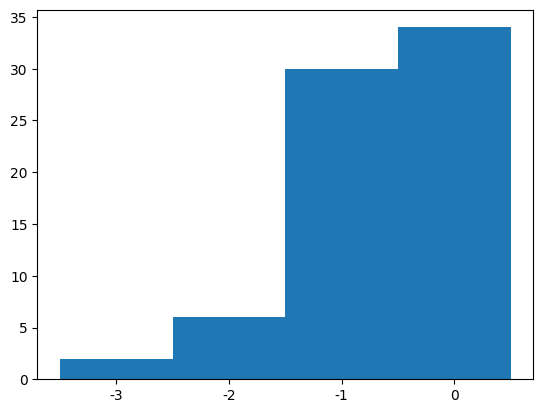

In [40]:
n, bins, patches = plt.hist(pt_avg, bins=len(set(pt_avg)))
ticks = [(patch._x0 + patch._width/2) for patch in patches]
ticklabels = sorted([i for i in set(pt_avg)])
plt.xticks(ticks, ticklabels)
plt.show()

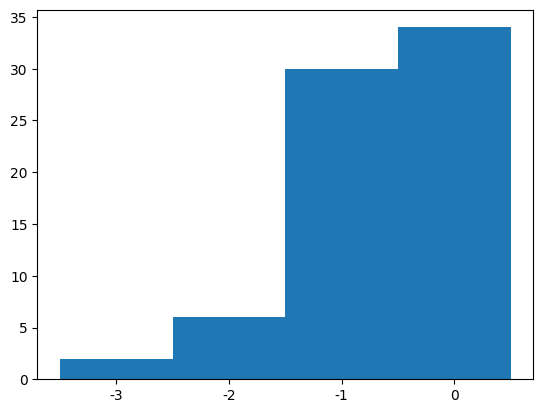

In [41]:
n, bins, patches = plt.hist(pt_max, bins=len(set(pt_max)))
ticks = [(patch._x0 + patch._width/2) for patch in patches]
ticklabels = sorted([i for i in set(pt_max)])
plt.xticks(ticks, ticklabels)
plt.show()

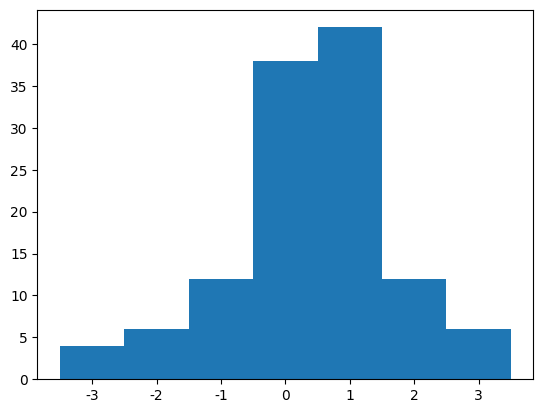

In [38]:
n, bins, patches = plt.hist(cvfs_avg, bins=len(set(cvfs_avg)))
ticks = [(patch._x0 + patch._width/2) for patch in patches]
ticklabels = sorted([i for i in set(cvfs_avg)])
plt.xticks(ticks, ticklabels)
plt.show()

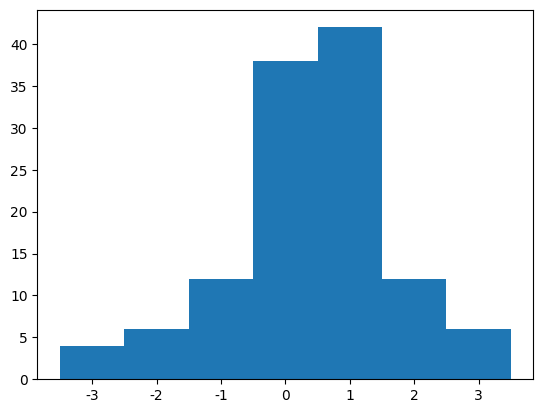

In [39]:
n, bins, patches = plt.hist(cvfs_max, bins=len(set(cvfs_max)))
ticks = [(patch._x0 + patch._width/2) for patch in patches]
ticklabels = sorted([i for i in set(cvfs_max)])
plt.xticks(ticks, ticklabels)
plt.show()